# Workflows and Agents

## Set up

In [1]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI()

## Building Blocks: The Augmented LLM

In [2]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_DXCkS3NMeXsd9uQzzUCZepOR',
  'type': 'tool_call'},
 {'name': 'multiply',
  'args': {'a': 3, 'b': 2},
  'id': 'call_1AyE9CGBWQ5EqmbyuHaXYPFT',
  'type': 'tool_call'}]

In [3]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='User wants to know how Calcium CT score is related to high cholesterol')

## Prompt chaining

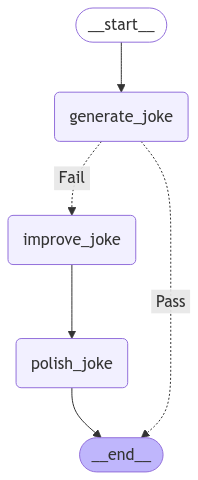

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Because it heard there were mice involved in the data processing!

--- --- ---

Final joke:
Why did the computer go to the cheese factory? Because it heard there were mice involved in the data processing...and it wanted to join in on the fun!


In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

## Parallelization

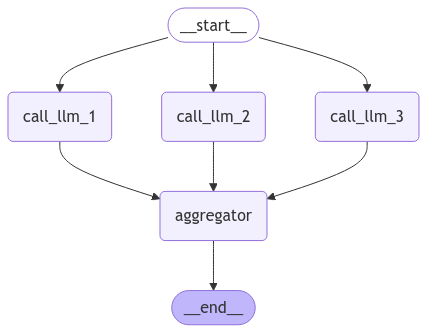

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a small village, there lived a group of stray cats who roamed the streets looking for food and shelter. Among them was a young and playful kitten named Whiskers, who was known for his curious nature and mischievous antics.

Whiskers loved exploring the village and would often sneak into people's homes to investigate and play with anything he could find. His favorite spot was the local fish market, where he would try to snatch a tasty morsel whenever the vendor turned his back.

One day, as Whiskers was wandering through the village, he stumbled upon a group of other cats who were huddled together under a tree. They seemed to be deep in conversation, their eyes wide with excitement.

Curious, Whiskers crept closer to listen in. The cats were talking about a magical place called the Cat Kingdom, where all cats lived in luxury and were treated like royalty. The Cat Kingdom was said to be filled with endless amounts of 

In [5]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## Routing

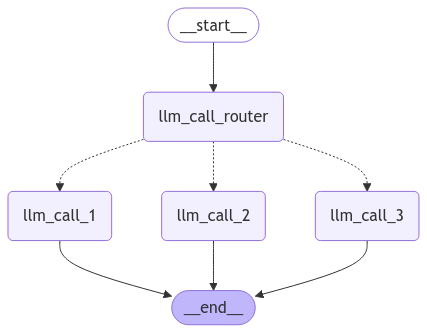

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [6]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## Orchestrator-Worker

In [7]:
from typing import Annotated, List
from pydantic import BaseModel
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

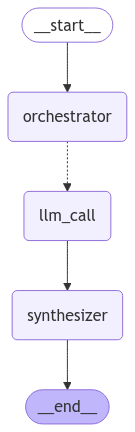

## Introduction

Scaling laws are mathematical relationships that describe how certain properties of a system change with scale. In the field of LLM (large language models), scaling laws play a crucial role in understanding the behavior and performance of these models as they grow in size. These laws provide insights into how factors such as computation, data, and model architecture interact to influence the capabilities and limitations of LLMs. Understanding and leveraging these scaling laws are essential for optimizing the design and deployment of large language models in various applications across fields such as natural language processing, machine learning, and artificial intelligence.

---

## Theory of LLM Scaling Laws

LLM scaling laws are based on the fundamental principles of fluid dynamics and heat transfer. These laws are derived from the governing equations that describe the behavior of liquid metal coolants in nuclear systems. The scaling laws take into account factors such as flow velocity, coolant temperature, geometry of the system, and material properties.

The derivation of LLM scaling laws involves simplifying the governing equations using assumptions and empirical correlations. By analyzing the dominant physical phenomena and their interactions, researchers can establish relationships between different parameters that govern the thermal-hydraulic behavior of liquid metal coolants. These relationships form the basis of the scaling laws that are used to predict the performance of LLM systems under various operating conditions.

---

## Applications of LLM Scaling Laws

Examples of how LLM scaling laws are applied in different fields such as physics, biology, and engineering.

---

## Challenges and Limitations

Discussion on the challenges and limitations of LLM scaling laws and areas for further research. 

- The scalability of LLMs faces challenges in terms of computational cost and memory requirements, especially for large language models with billions of parameters. This limits their practical utility in real-world applications where computational resources are constrained.

- Another limitation of LLM scaling laws is the issue of interpretability and explainability. As models increase in size and complexity, understanding and interpreting their decisions becomes increasingly challenging, raising concerns about trust and accountability in AI systems.

- Further research is needed to explore techniques for reducing the computational cost and memory requirements of large language models while maintaining their performance. This could involve exploring more efficient architectures, training procedures, or compression techniques to make LLMs more accessible and practical for a wider range of applications.

- Additionally, research into improving the interpretability of LLMs is crucial to address concerns around transparency and accountability in AI systems. Developing methods for explaining model decisions and understanding the underlying mechanisms of large language models will be key to unlocking their full potential in various domains.

---

## Conclusion

The LLM scaling laws have proven to be invaluable in scientific research, providing a framework for understanding and predicting the behavior of complex systems. By examining the relationships between various parameters, researchers have been able to uncover fundamental principles that govern the scaling of processes across different scales. The key points discussed in this report highlight the importance of LLM scaling laws in elucidating the dynamics of diverse phenomena, from biological systems to physical processes. Moving forward, further exploration and application of these scaling laws are likely to yield new insights and advancements in a wide range of fields.

In [8]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])